In [ ]:
!pip install selenium webdriver_manager phonenumbers openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 27.1 MB/s eta 0:00:00


In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import re
import phonenumbers
import pandas as pd
import time
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt

In [ ]:
!apt-get update
!apt-get install -y wget unzip
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb
!apt-get -f install -y
!wget -O /usr/local/bin/chromedriver https://chromedriver.storage.googleapis.com/114.0.5735.90/chromedriver_linux64.zip
!chmod +x /usr/local/bin/chromedriver


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,466 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,452 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages 

In [ ]:
import time
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import re
from bs4 import BeautifulSoup
from selenium import webdriver
import phonenumbers


from selenium.webdriver.chrome.options import Options

def fetch_content_with_selenium(url):
    chrome_options = Options()
    chrome_options.add_argument("--headless")  # Enable headless mode
    chrome_options.add_argument("--no-sandbox")  # Necessary for Colab
    chrome_options.add_argument("--disable-dev-shm-usage")  # Overcome limited resource problems
    driver = webdriver.Chrome(options=chrome_options)  # Ensure ChromeDriver is installed

    driver.get(url)
    content = driver.page_source  # Get the page HTML content
    driver.quit()  # Close the browser
    return content



def extract_contact_info(content, default_region="US"):
    soup = BeautifulSoup(content, "html.parser")

    # Patterns for emails and phone numbers
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    phone_pattern = r'\+?\d[\d\s.-]{6,}\d'  # Capture phone numbers with 7 or more digits

    # Find email addresses
    emails = set(re.findall(email_pattern, content))
    for tag in soup.find_all('a', href=True):
        if tag['href'].startswith('mailto:'):
            emails.add(tag['href'][7:])

    # Find phone numbers
    phones = re.findall(phone_pattern, content)
    valid_phones = set()
    for phone in phones:
        phone = re.sub(r'[^\d+]', '', phone)  # Remove all characters except digits and +

        # Attempt parsing with the provided region for numbers without country codes
        try:
            parsed_number = phonenumbers.parse(phone, default_region)
            if phonenumbers.is_valid_number(parsed_number):
                formatted_number = phonenumbers.format_number(parsed_number, phonenumbers.PhoneNumberFormat.INTERNATIONAL)
                valid_phones.add(formatted_number)
        except phonenumbers.NumberParseException:
            continue

    return list(emails), list(valid_phones)

def try_fetch_content_with_suffixes(url):
    suffixes = ["contact", "contact-us", "help", "pages/contact", "pages/contact-us"]
    content = fetch_content_with_selenium(url)
    emails, phones = extract_contact_info(content)

    if not emails and not phones:
        for suffix in suffixes:
            try:
                content = fetch_content_with_selenium(f"{url.rstrip('/')}/{suffix}")
                emails, phones = extract_contact_info(content)
                if emails or phones:  # Stop if any contact info is found
                    break
            except Exception as e:
                print(f"Failed to access URL {url}/{suffix}: {e}")

    return emails, phones

def read_input(links):
    results = []  # To store data for Excel output
    total_links = len(links)
    start_time = time.time()

    for i, url in enumerate(links, 1):
        try:
            emails, phones = try_fetch_content_with_suffixes(url)

            results.append({
                "URL": url,
                "Emails": ", ".join(emails) if emails else "No emails found",
                "Phone Numbers": ", ".join(phones) if phones else "No phone numbers found"
            })

        except Exception as e:
            print(f"Failed to process URL {url}: {e}")
            results.append({
                "URL": url,
                "Emails": "Error",
                "Phone Numbers": "Error"
            })

        # Progress and time estimation
        elapsed_time = time.time() - start_time
        progress = (i / total_links) * 100
        avg_time_per_url = elapsed_time / i
        estimated_remaining_time = avg_time_per_url * (total_links - i)

        print(f"Progress: {progress:.2f}% - Processed {i} out of {total_links} URLs")
        print(f"Elapsed time: {elapsed_time:.2f} seconds, Estimated remaining time: {estimated_remaining_time:.2f} seconds")

    # Convert results to DataFrame and save to Excel
    df_results = pd.DataFrame(results)
    df_results.to_excel("out_info40.1.xlsx", index=False)
    print("Results saved ")

# File selection dialog
 #root = tk.Tk()
#root.withdraw()  # Hide the Tkinter window
#file_path = filedialog.askopenfilename()  # Open file dialog


file_path= "40.1out.xlsx"
column_name = "URL"

def read_links_from_excel(file_path, column_name):
    df = pd.read_excel(file_path)
    return df[column_name].tolist()


# Read links from the selected file and process
links = read_links_from_excel(file_path, column_name)
read_input(links)


Progress: 0.06% - Processed 1 out of 1676 URLs
Elapsed time: 4.11 seconds, Estimated remaining time: 6884.62 seconds
Progress: 0.12% - Processed 2 out of 1676 URLs
Elapsed time: 8.20 seconds, Estimated remaining time: 6863.36 seconds
Progress: 0.18% - Processed 3 out of 1676 URLs
Elapsed time: 12.42 seconds, Estimated remaining time: 6927.66 seconds
Progress: 0.24% - Processed 4 out of 1676 URLs
Elapsed time: 18.34 seconds, Estimated remaining time: 7666.81 seconds
Progress: 0.30% - Processed 5 out of 1676 URLs
Elapsed time: 23.89 seconds, Estimated remaining time: 7985.64 seconds
Progress: 0.36% - Processed 6 out of 1676 URLs
Elapsed time: 25.77 seconds, Estimated remaining time: 7171.81 seconds
Progress: 0.42% - Processed 7 out of 1676 URLs
Elapsed time: 27.61 seconds, Estimated remaining time: 6582.51 seconds
Progress: 0.48% - Processed 8 out of 1676 URLs
Elapsed time: 30.71 seconds, Estimated remaining time: 6403.86 seconds
Progress: 0.54% - Processed 9 out of 1676 URLs
Elapsed tim

KeyboardInterrupt: 

                                                 URL  \
0                     https://soundinvestmentav.com/   
1  https://www.yelp.com/biz/hopkins-michael-t-cpa...   
2  https://find-and-update.company-information.se...   
3                                 http://eiteam.com/   
4  https://m.yelp.com/biz/lakeside-mercantile-dad...   

                                              Emails  \
0                         info@soundinvestmentav.com   
1  40x40_claim_your_page_v2@2x.yji-bd2968af365428...   
2                    enquiries@companieshouse.gov.uk   
3                               HMansouri@EITeam.com   
4  40x40_claim_your_page_v2@2x.yji-bd2968af365428...   

                                       Phone Numbers  
0  +1 510-291-5103, +1 913-425-0951, +1 800-720-8...  
1  +1 216-582-1251, +1 757-501-1150, +1 757-501-0...  
2                             No phone numbers found  
3                             No phone numbers found  
4  +1 216-582-1251, +1 757-501-1150, +1 334-811-2..

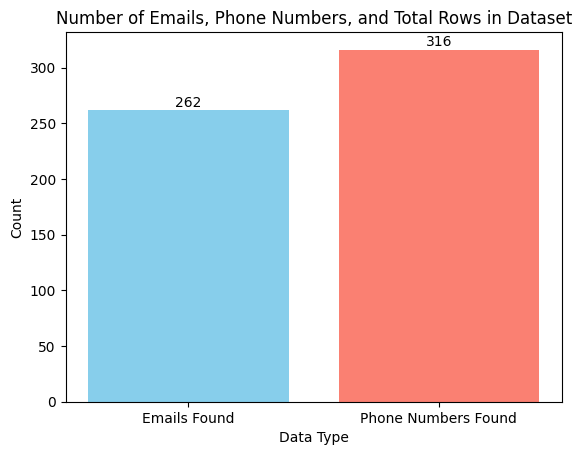

                                                 URL  \
0                     https://soundinvestmentav.com/   
1  https://www.yelp.com/biz/hopkins-michael-t-cpa...   
2  https://find-and-update.company-information.se...   
3                                 http://eiteam.com/   
4  https://m.yelp.com/biz/lakeside-mercantile-dad...   

                                              Emails  \
0                         info@soundinvestmentav.com   
1  40x40_claim_your_page_v2@2x.yji-bd2968af365428...   
2                    enquiries@companieshouse.gov.uk   
3                               HMansouri@EITeam.com   
4  logo_desktop_xsmall_outline@2x.png, burst_desk...   

                                       Phone Numbers  
0  +1 510-315-1029, +1 915-566-5921, +1 800-720-8...  
1  +1 529-535-2953, +1 214-748-3645, +1 757-501-0...  
2                             No phone numbers found  
3                             No phone numbers found  
4                             No phone numbers foun

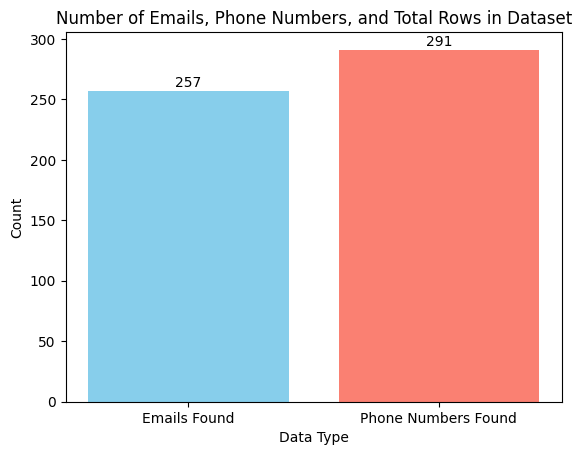

In [ ]:
# Seçilen dosyayı pandas DataFrame olarak oku
df = pd.read_excel("/content/out_info2.xlsx")

# Veri setini görüntüle
print(df.head())

# E-posta ve telefon numarası içeren hücreleri say
email_count = df['Emails'].str.contains('@', na=False).sum()
phone_count = df['Phone Numbers'].str.contains(r'\d', na=False).sum()  # Telefon numarası içeriyor mu kontrol eder
# Verileri görselleştirmek için sözlük oluştur
data = {
    'Emails Found': email_count,
    'Phone Numbers Found': phone_count,
}

# Çubuk grafiği oluşturma
fig, ax = plt.subplots()
bars = ax.bar(data.keys(), data.values(), color=['skyblue', 'salmon', 'lightgreen'])

# Her çubuğun üzerine değerini yazma
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

# Grafik başlıkları ve etiketler
ax.set_title('Number of Emails, Phone Numbers, and Total Rows in Dataset')
ax.set_ylabel('Count')
ax.set_xlabel('Data Type')

# Grafiği göster
plt.show()
# Seçilen dosyayı pandas DataFrame olarak oku
df = pd.read_excel("/content/out_info2.1.xlsx")

# Veri setini görüntüle
print(df.head())
# E-posta ve telefon numarası içeren hücreleri say
email_count = df['Emails'].str.contains('@', na=False).sum()
phone_count = df['Phone Numbers'].str.contains(r'\d', na=False).sum()  # Telefon numarası içeriyor mu kontrol eder
# Verileri görselleştirmek için sözlük oluştur
data = {
    'Emails Found': email_count,
    'Phone Numbers Found': phone_count,
}

# Çubuk grafiği oluşturma
fig, ax = plt.subplots()
bars = ax.bar(data.keys(), data.values(), color=['skyblue', 'salmon', 'lightgreen'])

# Her çubuğun üzerine değerini yazma
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

# Grafik başlıkları ve etiketler
ax.set_title('Number of Emails, Phone Numbers, and Total Rows in Dataset')
ax.set_ylabel('Count')
ax.set_xlabel('Data Type')

# Grafiği göster
plt.show()